# Data analytics final project

*Dominik Woźniak, 2022*

## Dataset
Dataset basing on golf putting data, typed in from Don Berry’s 1996 textbook. The columns are distance in feet from the hole, number of tries, and number of successes.

In [1]:
import io
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy
import scipy.stats as st

In [2]:
plt.rcParams["figure.figsize"] = (12,6)
# az.style.use("arviz-darkgrid")

In [3]:
data = pd.read_csv('data.csv')

In [4]:
data.head()

,x,n,y
0,2,1443,1346
1,3,694,577
2,4,455,337
3,5,353,208
4,6,272,149


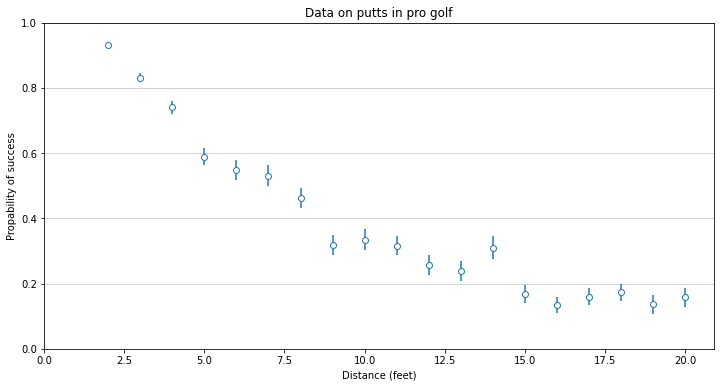

In [5]:
def plot_golf_data(data, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    bg_color = ax.get_facecolor()
    rv = st.beta(data.y, data.n - data.y)
    ax.vlines(data.x, *rv.interval(0.68), label=None)
    ax.plot(
        data.x, data.y / data.n, "o", mfc=bg_color, label=None
    )

    ax.set_title('Data on putts in pro golf')
    ax.set_xlabel('Distance (feet)')
    ax.set_ylabel('Propability of success')
    ax.set_ylim(bottom=0, top=1)
    
    ax.set_xlim(left=0)
    ax.grid(True, axis="y", alpha=0.7)
    return ax


ax = plot_golf_data(data)

### Build logistic model

In [6]:
from cmdstanpy import CmdStanModel

In [7]:
golf_data = {
    "x": data.x,
    "y": data.y,
    "n": data.n,
    "J": 19
}

In [8]:
model_logistic = CmdStanModel(stan_file='logistic.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [11]:
fit_logistic = model_logistic.sample(
    data=golf_data,
    iter_sampling=4000,
    iter_warmup=1000,
    chains=4
)

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [12]:
dataframe_draws = fit_logistic.draws_pd()

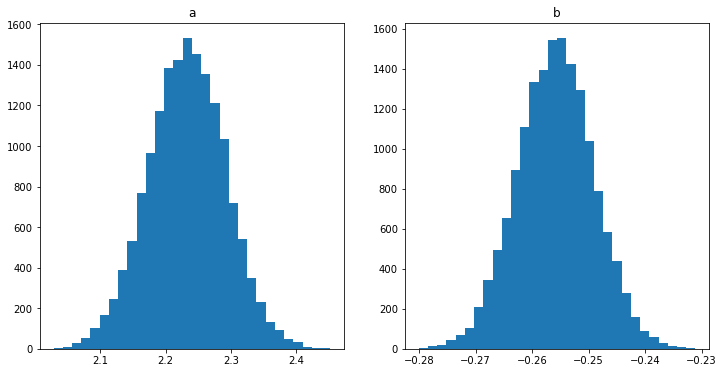

In [13]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('a')
plt.hist( dataframe_draws['a'], bins=30)
plt.subplot(122)
plt.title('b')
plt.hist( dataframe_draws['b'], bins=30)
plt.show()

In [14]:
inference_data = az.from_cmdstanpy(fit_logistic)
inference_data

Inference data with groups:
	> posterior
	> sample_stats

In [15]:
dataframe_draws.describe()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,a,b
count,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.0,16000.000000,16000.000000,16000.000000
mean,-3021.171909,0.929771,0.389086,2.238625,6.203750,0.0,3022.185433,2.232638,-0.255906
std,1.014512,0.101304,0.020598,0.716129,3.716026,0.0,1.432021,0.059030,0.006732
min,-3028.690000,0.104549,0.365853,1.000000,1.000000,0.0,3020.160000,2.027950,-0.280082
25%,-3021.570000,0.906233,0.378100,2.000000,3.000000,0.0,3021.130000,2.192798,-0.260450
50%,-3020.850000,0.972001,0.384118,2.000000,7.000000,0.0,3021.850000,2.233195,-0.255839
75%,-3020.450000,0.996540,0.395104,3.000000,7.000000,0.0,3022.880000,2.272952,-0.251367
max,-3020.150000,1.000000,0.422257,4.000000,15.000000,0.0,3034.480000,2.452490,-0.231114


In [16]:
a_mean = dataframe_draws['a'].mean()
b_mean = dataframe_draws['b'].mean()

<AxesSubplot:title={'center':'b'}>

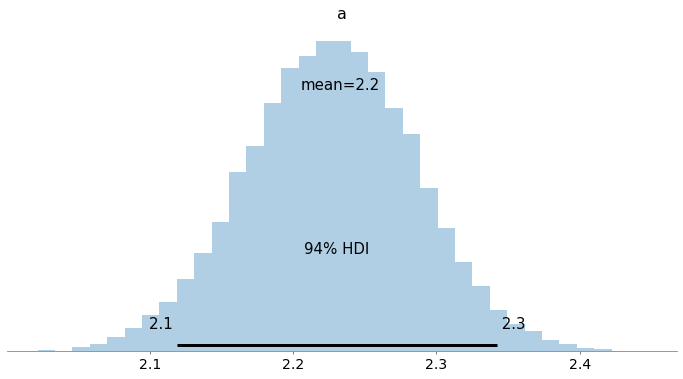

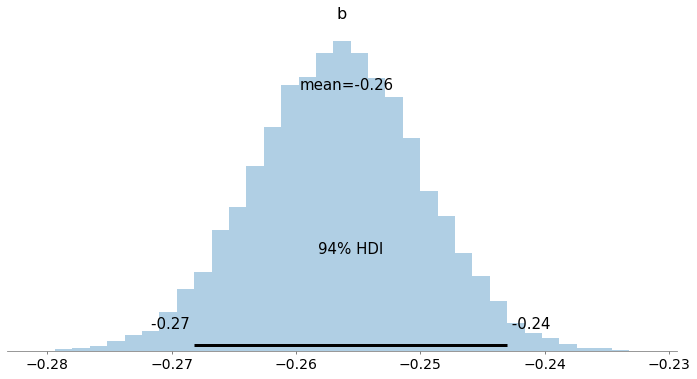

In [19]:
az.plot_posterior(fit_logistic, var_names=['a'], round_to=2, kind='hist', bins=35)
az.plot_posterior(fit_logistic, var_names=['b'], round_to=2, kind='hist', bins=35)